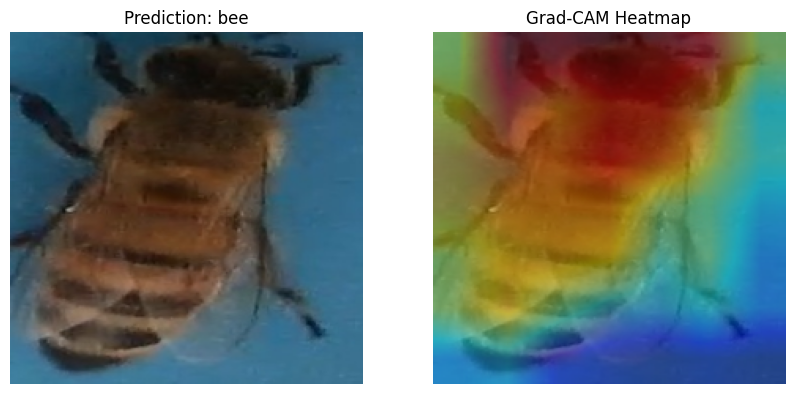

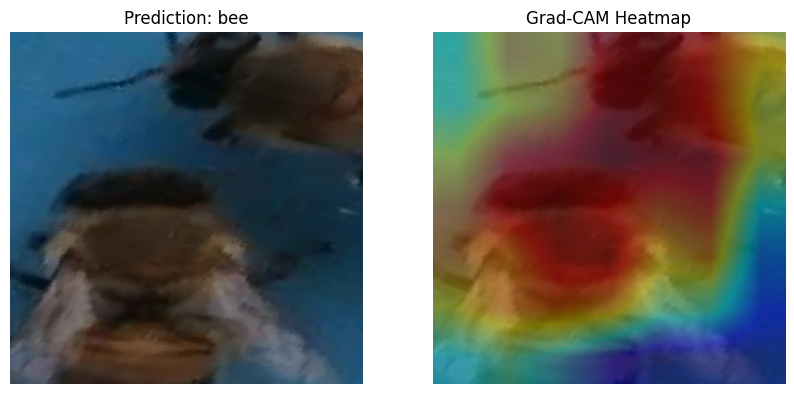

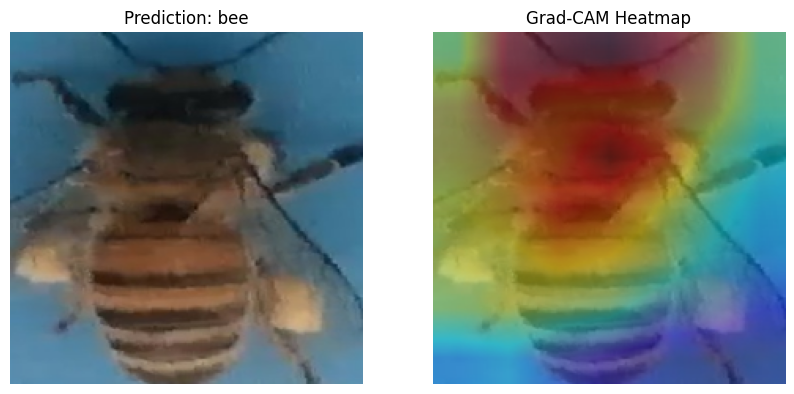

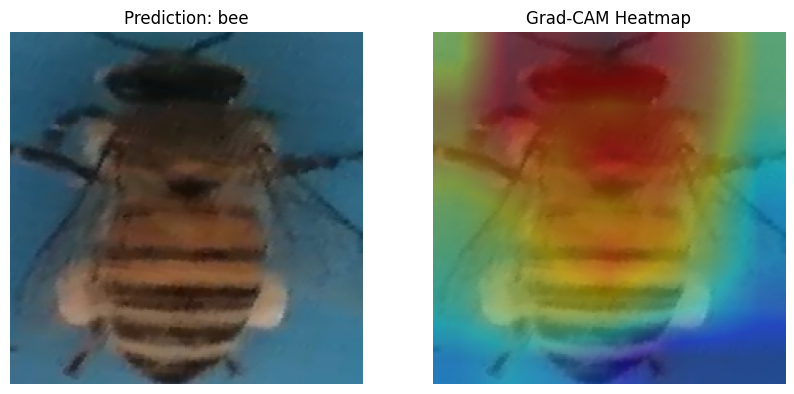

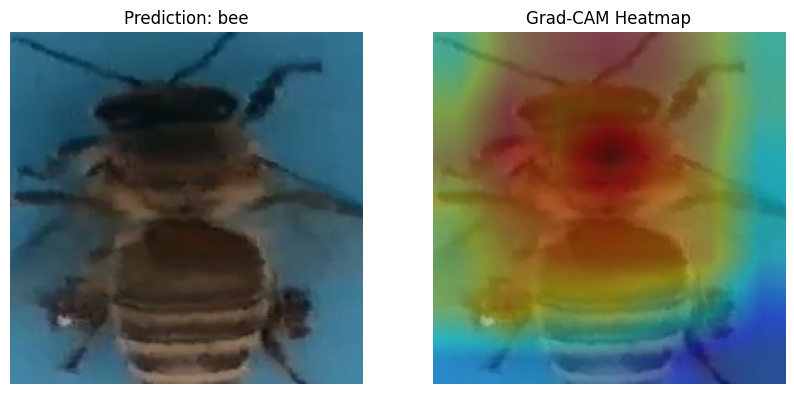

In [66]:
import torch
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import os
import cv2

# Grad-CAM implementation
class GradCAM:
    """
    Implement Grad-CAM for visualizing the regions of an image 
    that are most important for a model's prediction
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []

        # Register hooks to capture activations and gradients
        self.hook_handles.append(target_layer.register_forward_hook(self.save_activations))
        self.hook_handles.append(target_layer.register_backward_hook(self.save_gradients))

    def save_activations(self, module, input, output):
        """
        Save feature maps during the forward pass
        Args:
            module: The layer being hooked
            input: Input to the layer
            output: Output of the layer
        """
        self.activations = output

    def save_gradients(self, module, grad_input, grad_output):
        """
        Save gradients during the backward pass
        Args:
            module: The layer being hooked
            grad_input: Gradients flowing into the layer
            grad_output: Gradients flowing out of the layer
        """
        self.gradients = grad_output[0]

    def generate_heatmap(self, class_idx):
        """
        Generate a Grad-CAM heatmap for the given class index
        Args:
            class_idx: Index of the class for which the heatmap is generated
        Returns:
            A normalized 2D heatmap highlighting important regions
        """
        weights = torch.mean(self.gradients, dim=(2, 3))
        heatmap = torch.sum(weights[:, :, None, None] * self.activations, dim=1).squeeze()
        heatmap = np.maximum(heatmap.detach().cpu().numpy(), 0)
        heatmap /= heatmap.max()
        return heatmap

    def remove_hooks(self):
        """
        Remove all registered hooks to avoid memory issues
        """
        for handle in self.hook_handles:
            handle.remove()

# Load the model and prepare for Grad-CAM
model = models.resnet50(pretrained=False)
num_classes = 2 
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

# Load pretrained weights
state_dict = torch.load("bee_wasp.pth", map_location=torch.device('cpu'))
model.eval()

# Preprocessing pipeline for input images
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Random 5 images
folder = "kaggle_bee_vs_wasp/bee2"
images = random.sample(os.listdir(folder), 5)

# Specify the target layer for Grad-CAM
target_layer = model.layer4[2].conv3 
grad_cam = GradCAM(model, target_layer)

# Process each image and generate Grad-CAM visualizations
for img_name in images:
    img_path = os.path.join(folder, img_name)
    img = Image.open(img_path).convert("RGB")
    input_tensor = preprocess(img).unsqueeze(0)

    # Forward pass to get model predictions
    output = model(input_tensor)
    class_idx = output.argmax(dim=1).item()
    class_name = "bee" if class_idx == 1 else "wasp"

    # Backward pass to compute gradients for the predicted class
    model.zero_grad()
    target = output[0, class_idx]
    target.backward()

    # Generate Grad-CAM heatmap
    heatmap = grad_cam.generate_heatmap(class_idx)
    heatmap_resized = cv2.resize(heatmap, (224, 224))

    # Normalize heatmap for visualization
    heatmap_normalized = heatmap_resized - heatmap_resized.min()
    heatmap_normalized /= heatmap_normalized.max()

    # Convert heatmap to color
    heatmap_colored = cv2.applyColorMap((heatmap_normalized * 255).astype(np.uint8), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

    # Overlay heatmap on the original image
    img_np = np.array(img.resize((224, 224)))
    overlay = (0.6 * img_np / 255.0 + 0.4 * heatmap_colored / 255.0)
    overlay = (overlay * 255).astype(np.uint8)

    # Display the original image and Grad-CAM visualization
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title(f"Prediction: {class_name}")
    plt.imshow(img_np)
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.title(f"Grad-CAM Heatmap")
    plt.imshow(overlay)
    plt.axis("off")
    plt.show()

grad_cam.remove_hooks()